In [1]:
from spektral.datasets import qm9
from spektral.layers import GraphConv
from spektral.utils import label_to_one_hot

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED

import numpy as np
import tensorflow as tf
import spektral

from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras.utils import plot_model

spktrl = spektral.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
A, X, E, y = qm9.load_data(return_type='numpy',
                          nf_keys='atomic_num',
                          ef_keys='type',
                          self_loops=True)

Loading QM9 dataset.
Reading SDF


In [3]:
A.shape, X.shape, E.shape

((133885, 9, 9), (133885, 9, 1), (133885, 9, 9, 1))

In [4]:
# Train/test split
A_train, A_test, \
X_train, X_test, \
E_train, E_test, \
y_train, y_test = train_test_split(A, X, E, y, test_size=0.1, random_state=0)

In [5]:
# Parameters
N = A[0].shape[-2]
F = X[0].shape[-1]
S = E[0].shape[-1]

In [6]:
N, F, S

(9, 1, 1)

In [7]:
################################################################################
# BUILD ENCODER MODEL
################################################################################

encoded_size = 4 # size of latent variable Z
base_depth = 32 # conv filters

X_in = tfkl.Input(shape=(N,F))
A_in = tfkl.Input(shape=(N,N))
E_in = tfkl.Input(shape=(N, N, S))

In [8]:
def sampling(args):
    """Reparameterization trick --> sampling from Gaussian
       args: mean, log_sigma_sq of q(z|x)
       returns latent variable z
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[1]
    dim = K.int_shape(z_mean)[2]
    
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + K.exp(.5*z_log_var)*epsilon

In [9]:
# build encoder
inputs = ([X_in, A_in])
x = spktrl.GraphConv(base_depth, 'relu')(inputs)
z_mean = spktrl.GraphConv(encoded_size, 'relu')([x, A_in])
z_log_var = spktrl.GraphConv(encoded_size, 'relu')([x, A_in])

In [10]:
# reparameterization trick
z = tfkl.Lambda(sampling, output_shape=(encoded_size,))([z_mean, z_log_var])

In [11]:
# instantiate encoder
encoder = tfk.Model(inputs, [z_mean, z_log_var, z])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9, 9)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 9, 32)        64          input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 9, 4)         132         graph_conv[0][0]             

In [12]:
class InnerProductDecoder(layers.Layer):

  def __init__(self, input_dim):
    super(InnerProductDecoder, self).__init__()
    self.input_dim = input_dim

  def call(self, inputs):
    x = tf.linalg.matmul(inputs, inputs, transpose_b=True)
    
    return tf.sigmoid(x)

In [13]:
# build decoder
latent_inputs = tfkl.Input((N,encoded_size,))
A_hat = InnerProductDecoder(N)(latent_inputs) 
#A_hat = tfkl.Dense(N,'sigmoid')(latent_inputs) 

In [14]:
# instantiate decoder

decoder = tfk.Model(latent_inputs, A_hat)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 9, 4)]            0         
_________________________________________________________________
inner_product_decoder (Inner (None, 9, 9)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [15]:
# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = tfk.Model(inputs, outputs)

In [16]:
decoder(z)

<tf.Tensor 'model_1_1/Identity:0' shape=(None, 9, 9) dtype=float32>

In [17]:
# E[logP(A|Z)]
reconstruction_loss = mse(inputs[1], decoder(z))

In [18]:
# D_kl(Q(Z|X)||P(Z))
kl_loss = 0.5*K.sum(K.exp(z_log_var) + K.square(z_mean) - 1. - z_log_var, axis=-1)

In [19]:
vae_loss = K.mean(reconstruction_loss+kl_loss)
vae.add_loss(vae_loss)

In [25]:
vae.compile(optimizer='adam')
vae._layers = [layer for layer in vae._layers if not isinstance(layer, dict)]

In [21]:
vae.metrics.append(vae_loss)
vae.metrics_names.append("vae_loss")

In [22]:
vae.summary()   

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9, 9)]       0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 9, 4), (None 328         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 9, 9)         0           model[1][0]                

In [23]:
vae.fit([X_train, A_train],[X_train, A_train],epochs=15,batch_size=32)

Epoch 1/15
3766/3766 [==============================] - 4s 933us/step - loss: 96.8629
Epoch 2/15
3766/3766 [==============================] - 3s 901us/step - loss: 0.4949
Epoch 3/15
3766/3766 [==============================] - 3s 882us/step - loss: 0.3053
Epoch 4/15
3766/3766 [==============================] - 3s 860us/step - loss: 0.3055
Epoch 5/15
3766/3766 [==============================] - 3s 833us/step - loss: 0.3047
Epoch 6/15
3766/3766 [==============================] - 3s 816us/step - loss: 0.3055
Epoch 7/15
3766/3766 [==============================] - 3s 847us/step - loss: 0.3047
Epoch 8/15
3766/3766 [==============================] - 3s 852us/step - loss: 0.3063
Epoch 9/15
3766/3766 [==============================] - 3s 846us/step - loss: 0.3051
Epoch 10/15
3766/3766 [==============================] - 3s 826us/step - loss: 0.3053
Epoch 11/15
3766/3766 [==============================] - 3s 831us/step - loss: 0.3062
Epoch 12/15
3766/3766 [==============================] - 3s 84

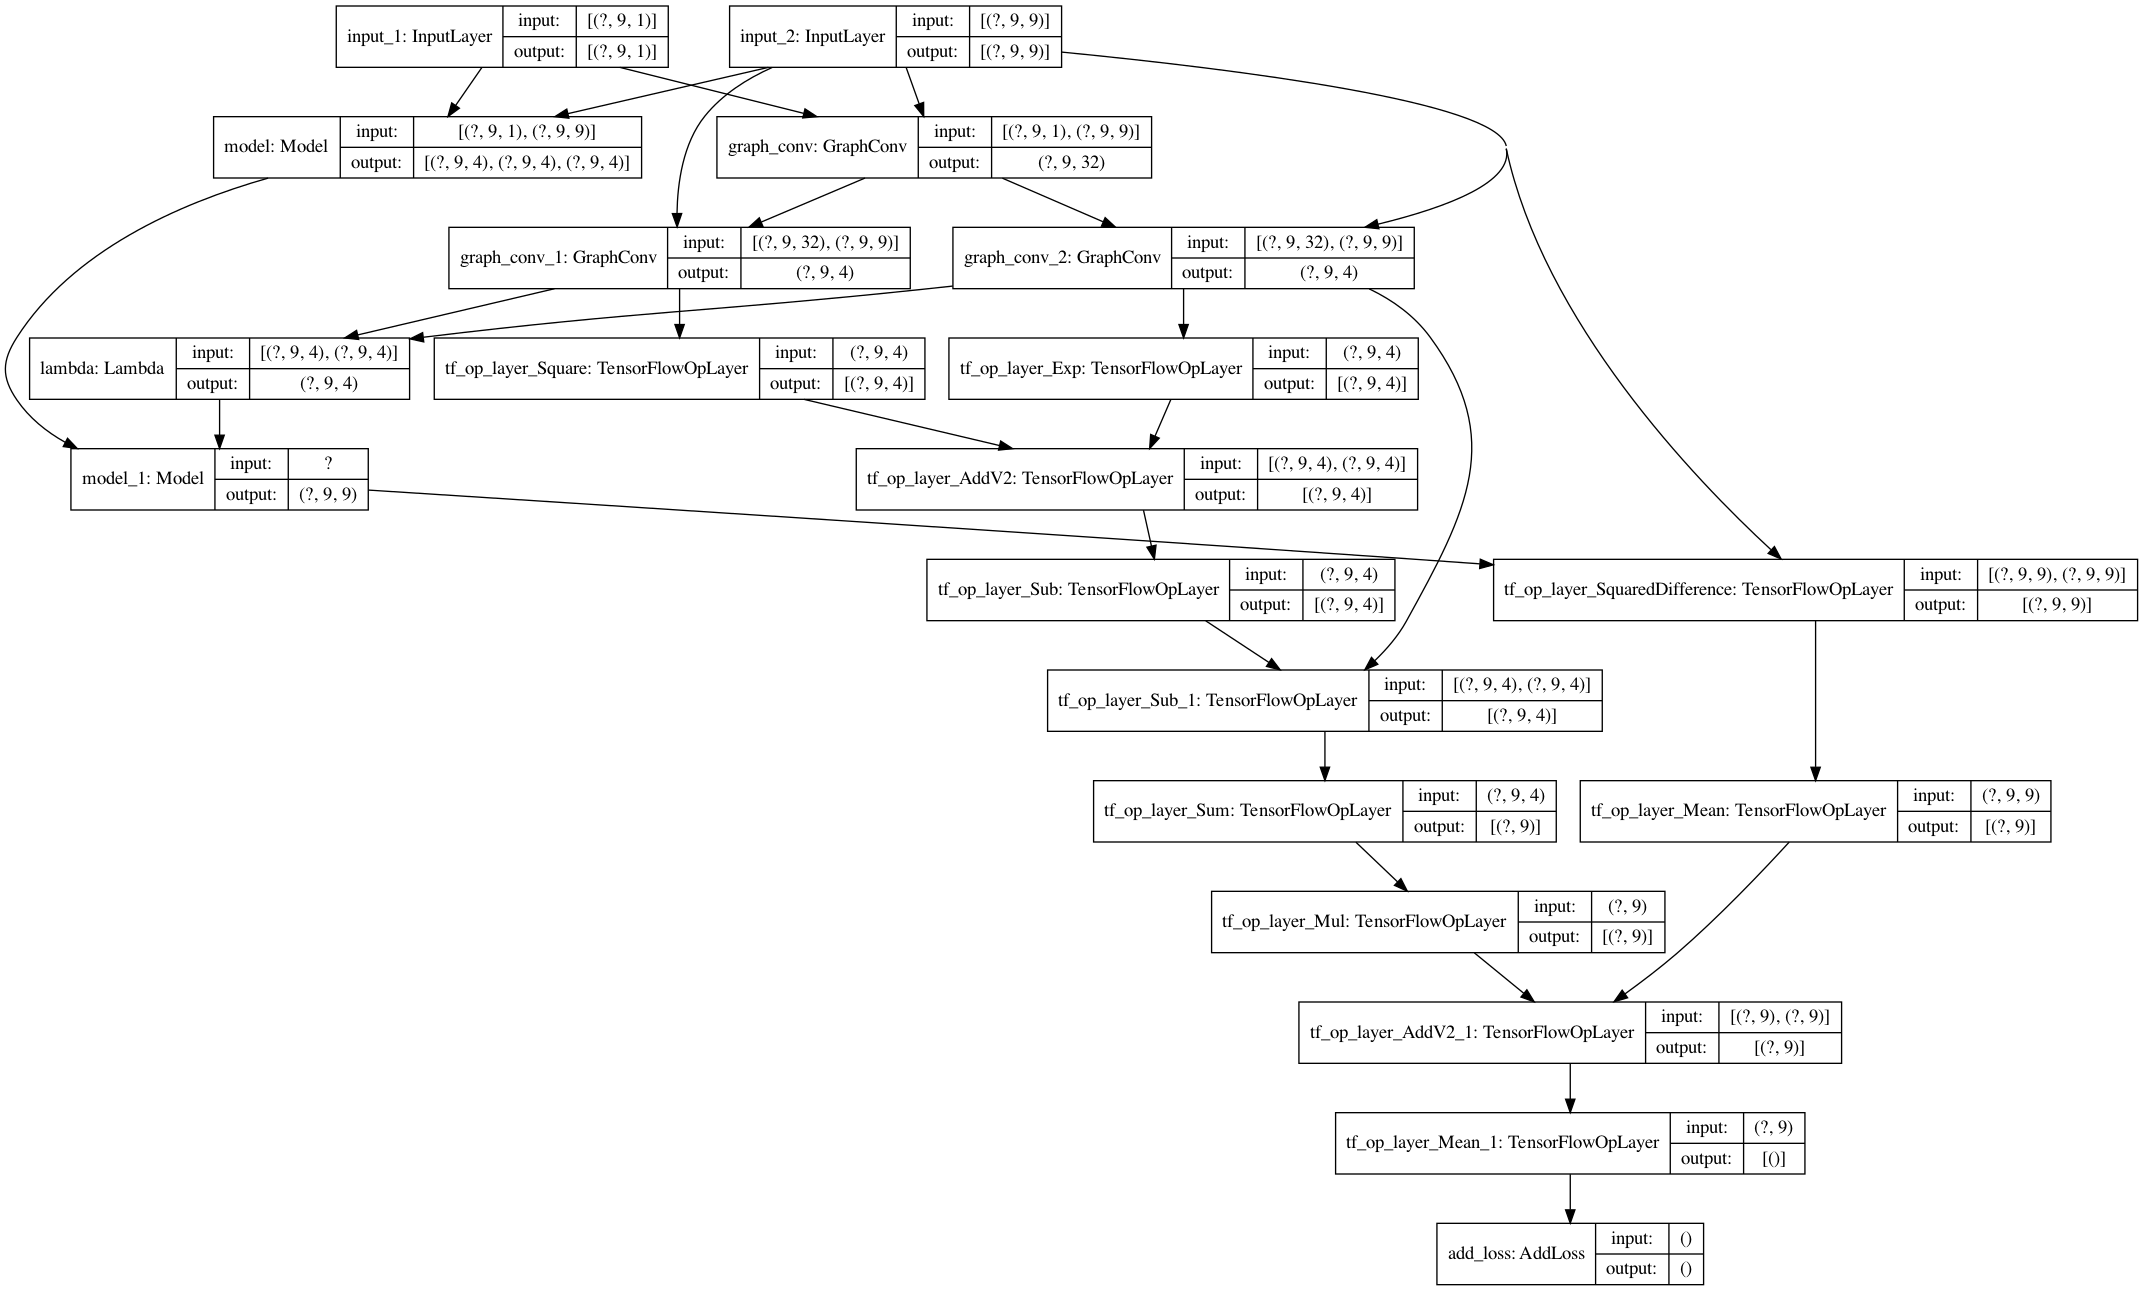

In [26]:
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)